# How to create a Lambda Function for Image Classifcation in AWS Panorama 

## What this notebook accomplishes

- How to create and deploy a lambda function that is used for a semantic segmentation application using the AWS Panorama service. 
- You will learn the parts of an Panorama application and what they are used for. 
- Then you will put it all together to simulate an image classification application within the environment of this notebook. 


The application uses a pretrained image classification model from GluonCV/MXNET. You can find more information and tutorials for image classification using [MXNET & GluonCV](https://gluon-cv.mxnet.io/build/examples_classification/index.html) tools. 

**Frames to Process**:

* By default, we only process 10 frames from the video. If you want to increase this, please change this value in /panorama_sdk/panoramasdk.py and change frames_to_process = 10 to a value of your choice

In [1]:
!pip3 install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


#### Change video to use

In [2]:
video_to_use = "mountain.mp4" 

#### Import Roles

In [3]:
import sagemaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# Getting Started

## 1. What is Image Classification

- Image Classification is one of few foundational computer vision tasks that provide the basis for performing other more difficult tasks. 
- Object detection is an example of a CV Task that uses a pretrained base trained using an image classification dataset. 
- With image classification, we are simply trying to classify what the image is, i.e *a cat or dog*
- An application of this is a farmer trying to classify tomatoes as good or bad as part of their sorting process. 
- Another could be a wood sourcer that needs to determine which cuts of wood can be used and which ones cannot. 

#### 1.1 The end to end process for Image Classification inference is relatively simple. 
- It consists of taking an image (or in this case a video frame) and preprocessing it
- performing model inference
- post-processing model's output to determine what class the image belongs to

#### 1.2 Run the next cell to define the preprocessing functions. 
These functions are responsible for performing transformations and normalizing so that inference performs well.

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def preprocess(
    img,
    resize_short=256,
    crop_size=224,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
):
    """"""

    # resize to resize short
    # find the short size,
    width = img.shape[0]
    height = img.shape[1]

    height_is_short = int(width > height)  #

    if height_is_short:
        width = int(width * (resize_short / height))
        height = resize_short
    else:
        height = int(height * (resize_short / width))
        width = resize_short

    img = cv2.resize(img, (height, width))

    # center crop
    xmin = int(width / 2 - crop_size / 2)
    xmax = int(width / 2 + crop_size / 2)
    ymin = int(height / 2 - crop_size / 2)
    ymax = int(height / 2 + crop_size / 2)

    img = img[xmin:xmax, ymin:ymax, :]
    # normalize

    img = normalize(img, mean=mean, std=std)

    return img


def normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    img = img.astype(np.float32) / 255.0  # converting array of ints to floats
    img_a = img[:, :, 0]
    img_b = img[:, :, 1]
    img_c = img[:, :, 2]

    # Extracting single channels from 3 channel image
    # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)

    # normalizing per channel data:
    img_a = (img_a - mean[0]) / std[0]
    img_b = (img_b - mean[1]) / std[1]
    img_c = (img_c - mean[2]) / std[2]

    # putting the 3 channels back together:
    x1 = [[[], [], []]]
    x1[0][0] = img_a
    x1[0][1] = img_b
    x1[0][2] = img_c

    # x1 = mx.nd.array(np.asarray(x1))
    x1 = np.asarray(x1)

    return x1


def softmax(logits):
    ps = np.exp(logits)
    ps /= np.sum(ps)

    return ps

#### 1.3 Next, read in the image and transform it. 

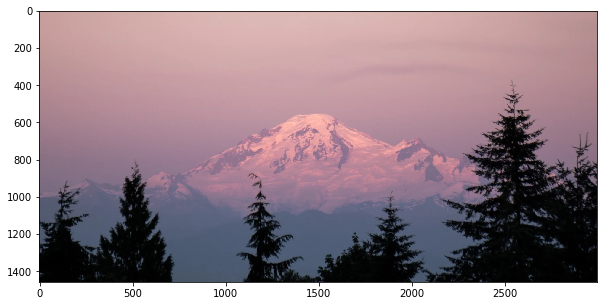

In [5]:
filename = "mt_baker.jpg"
img = cv2.imread(filename)

# x is in the input that goes directly into the model
x = preprocess(img)
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#### 1.4 Define a utility function for getting the indices of the top K probabilities

In [6]:
def topk(array, k=5):
    enum_vals = [(i, val) for i, val in enumerate(array)]
    sorted_vals = sorted(enum_vals, key=lambda tup: tup[1])
    top_k = sorted_vals[::-1][:k]
    return [tup[0] for tup in top_k]

#### 1.5 Load the model and perform inference

In [7]:
from imagenet_classes import get_classes
from gluoncv import model_zoo
import mxnet as mx

model = model_zoo.get_model("resnet50_v2", pretrained=True)
classes = get_classes()
logits = model(mx.nd.array(x))
probs = softmax(logits[0].asnumpy())

#### 1.6 Process model output and visualize results

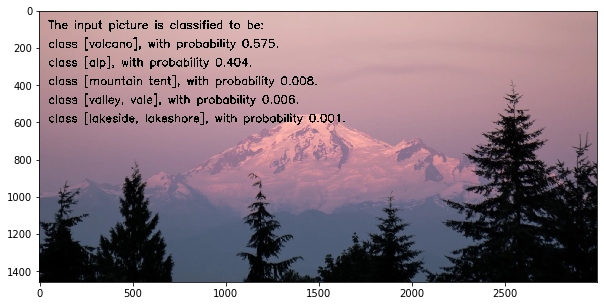

In [8]:
topK = 5
ind = topk(probs, k=topK)

top = "The input picture is classified to be:"
image = cv2.putText(
    img, top, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 5
)
for j in range(topK):
    line = "class [%s], with probability %.3f." % (
        classes[ind[j]],
        probs[ind[j]],
    )
    coords = (50, 100 + (j + 1) * 100)
    image = cv2.putText(
        image, line, coords, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 5
    )

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## 2. Building the lambda

The first step to building the Panorama application code that will be part of the lambda is understanding what parts of the **Panorama Application Class** are necessary. This class is what is used by the Panorama service to manage the model, preprocessing and prediction.

- At a high level, the raw code cell below is what the application class looks like. 
- The `interface`, `init`, and `entry` methods are the basic necessary components to building the application class.

**Note**: In addition to these methods, you can add custom methods either to the class or the script globally. You will see both illustrated in the final lambda function.

```
class image_classifier(panoramasdk.base):
    def interface(self):
        # defines the parameters that interface with other services from Panorama
        
    def init(self, parameters, inputs, outputs):
        # defines the attributes such as arrays and model objects that will be used in the application
        
    def entry(self, inputs, outputs):
        # defines the application logic responsible for predicting using the inputs and handles what to do 
        # with the outputs
```

### 2.1 Defining the `interface` method
The first method to define is the `interface` method. This is an important part of the Panorama application because this is how the application interacts with the resources from the Panorama service. When creating an Panorama Application in the Panorama console, you should have specified the model that will be used for predicting, the IP camera input streams and where the application's output is going. 
- The Panorama Service compiles your pretrained model and prepares it to be deployed to the Manhattan device. 
- Camera inputs are defined so that each camera's stream images are passed to the application to be predicted on by the AWS Lambda function's application code.
- Outputs are defined to receive the model's post-processed output. This is usually set to output to HDMI for visualizing results.

Lastly, the interface method then defines these inputs and outputs within the Panorama application class so that the application has access to them in the `entry` function. 

```
def interface(self):
    return {
        "parameters":
            (
                ("model", "classifier", "Model for classifying images", "classification-model"),
                ("int", "batch_size", "Model batch size", 1),
            ),
        "inputs":
            (
                ("media[]", "video_in", "Camera input stream"),
            ),
        "outputs":
            (
                ("media[video_in]", "video_out", "Camera output stream"),
            )
    }
```

The `interface` method returns a dictionary of items that define parameters, inputs and outputs. 
- These items consist of an array of tuples. 
- Each tuple follows this schema:

(`data type`, `variable name`, `description`, `value`)

**Tip**: You can add your own parameters to the `parameters` object, that can be later used in the `init` method. 

For this example, you will set the value of the `classifier` parameter to **"classification-model"**, and in the future you will set it to the name of the model you have defined to be part of the Panorama application in the Panorama Console. Batch size will always be 1.

### 2.2 Defining the `init` method

The init method serves a similar purpose to traditional `__init__` methods used in python classes. 
- The difference here is that the initialization parameters come from the `parameters` object passed. 
- Using this `parameters` object, you can initialize the model that has been previously uploaded in the Panorama Console. 
- You will also define array containers for the model's output based on the model's output shapes.

```
def init(self, parameters, inputs, outputs):
    try:
        self.frame_num = 0

        # Load model from the specified directory.
        print("loading the model...")
        self.model = panoramasdk.model()
        self.model.open(parameters.classifier, 1)
        print("model loaded")

        # Create input and output arrays.
        prob_info = self.model.get_output(0)
       
        self.prob_array = np.empty(prob_info.get_dims(), dtype=prob_info.get_type())
        
        return True

    except Exception as e:
        print("Exception: {}".format(e))
        return False
```

One thing to note, with the code below
```
...
self.model = panoramasdk.model()
self.model.open(parameters.classififier, 1)
...
```
First, an `panoramasdk.model` object is initialized, then the pretrained model is loaded into that object. 
- It knows what model to load based on the parameter you set in `interface` for the corrresponding model parameter. 
- In this notebook you will use a different pattern so that it can be demo-ed in a notebook environment, but it will behave similarly. 

### 2.3 Defining the `entry` method

The entry method is the *entry* point for the Panorama application; and it contains all the logic to perform for each video input, for each frame. This is where you will perform the preprocessing, inferencing, and post-processing. 
For the classification task, it's as simple as the following steps:

1. preprocess the image input
2. perform inference
3. get the results
4. filter out the top k most probable classes
5. add text to the stream.image displaying the k most probable classes

```
def entry(self, inputs, outputs):

    for i in range(len(inputs.video_in)):

        stream = inputs.video_in[i]

        person_image = stream.image

        print("Processing Image...")
        x1 = preprocess(person_image)
        print("Processed Image")


        # Do inference on the new frame.
        print("Performing Detector Inference")
        self.model.batch(0, x1)
        self.model.flush()
        print("Inference Completed.")

        # Get the results.
        resultBatchSet = self.model.get_result()

        prob_batch = resultBatchSet.get(0)
        prob_batch.get(0, self.prob_array)

        logits = self.prob_array[0]
        topK = 5
        ind = self.topk(pred, k=topK)

        probs = softmax(logits)
        lines = []
        for i in range(topK):
            lines.append('class [%s], with probability %.3f.'%
              (classes[ind[i]], probs[ind[i]]))
        message = "\n".join(lines)

        stream.add_label(message, 0.65, 0.65)



    self.model.release_result(resultBatchSet)
    outputs.video_out[i] = stream

    return True
```

### 2.4 Extra Methods 
As mentioned previously, you can add helpful methods to either the application class or the script globally. 
- The raw code cell below is an example of a helpful method added to the class. 
- It is defined the same way as you would for a typical python class. 
- Examples of adding custom functions globally are shown in the **Putting it all together** section.

```
def topk(self, array, k=5):
    enum_vals = [(i, val) for i, val in enumerate(array)]
    sorted_vals = sorted(enum_vals, key=lambda tup: tup[1])
    top_k = sorted_vals[::-1][:k]
    return [tup[0] for tup in top_k]
```

## 3. Putting it all together

A version of the lambda code compatible within a notebook environment has been written for you below. Run the next cell to visualize the application's output. 

In [11]:
import os
import sys
path = os.path.abspath(os.path.join(os.path.dirname("panorama_sdk"), '../..'))
sys.path.insert(1, path + '/panorama_sdk')
import jupyter_utils

jupyter_utils.change_video_source(video_to_use)

Video Changed to mountain.mp4


In [10]:
# Non Panorama Modules

import matplotlib.pyplot as plt
from IPython.display import clear_output, Markdown, display
plt.rcParams["figure.figsize"] = (20,20)


In [12]:
import panoramasdk
import cv2
import numpy as np
import time
import boto3
import json
from imagenet_classes import get_classes

#[AWS Panorama Documentation](https://docs.aws.amazon.com/panorama/)


def preprocess(img, resize_short=256, crop_size=224,
                   mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """
    """
    # resize to resize short
    # find the short size, 
    width = img.shape[0]
    height = img.shape[1]

    height_is_short = int(width > height) #

    if height_is_short:
        width = int(width * (resize_short/height))
        height = resize_short
    else:
        height = int(height * (resize_short/width))
        width = resize_short
    
    img = cv2.resize(img, (height, width))
    
    # center crop
    xmin = int(width/2 - crop_size/2)
    xmax = int(width/2 + crop_size/2)
    ymin = int(height/2 - crop_size/2)
    ymax = int(height/2 + crop_size/2)
    
    img = img[xmin:xmax, ymin:ymax, :]
    # normalize
    
    img = normalize(img, mean=mean, std=std)
    
    return img


def normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    img = img.astype(np.float32) / 255.  # converting array of ints to floats
    img_a = img[:, :, 0]
    img_b = img[:, :, 1]
    img_c = img[:, :, 2]

    # Extracting single channels from 3 channel image
    # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)

    # normalizing per channel data:
    img_a = (img_a - mean[0]) / std[0]
    img_b = (img_b - mean[1]) / std[1]
    img_c = (img_c - mean[2]) / std[2]

    # putting the 3 channels back together:
    x1 = [[[], [], []]]
    x1[0][0] = img_a
    x1[0][1] = img_b
    x1[0][2] = img_c

    # x1 = mx.nd.array(np.asarray(x1))
    x1 = np.asarray(x1)
    
    return x1    

def softmax(logits):
    ps = np.exp(logits)
    ps /= np.sum(ps)
    
    return ps

class image_classifier(panoramasdk.base):

    def interface(self):
        return {
            "parameters":
                (
                    ("model", "classifier", "Model for classifying images", "resnet50_v2"),
                    ("int", "batch_size", "Model batch size", 1),
                ),
            "inputs":
                (
                    ("media[]", "video_in", "Camera input stream"),
                ),
            "outputs":
                (
                    ("media[video_in]", "video_out", "Camera output stream"),
                )
        }


    def init(self, parameters, inputs, outputs):
        try:
            self.frame_num = 0
            # Load model from the specified directory.
            print("loading the model...")
            self.model = panoramasdk.model()
            self.model.open(parameters.classifier, 1)
            print("model loaded")

            # Create input and output arrays.
            prob_info = self.model.get_output(0)
            
            self.prob_array = np.empty(prob_info.get_dims(), dtype=prob_info.get_type())
            
            self.classes = get_classes()

            return True

        except Exception as e:
            print("Exception: {}".format(e))
            return False

    
    def topk(self, array, k=5):
        enum_vals = [(i, val) for i, val in enumerate(array)]
        sorted_vals = sorted(enum_vals, key=lambda tup: tup[1])
        top_k = sorted_vals[::-1][:k]
        return [tup[0] for tup in top_k]

    
    def entry(self, inputs, outputs):

        for i in range(len(inputs.video_in)):
            
            stream = inputs.video_in[i]
            image = stream.image

            x1 = preprocess(image)
        
            # Do inference on the new frame.
            self.model.batch(0, x1)
            self.model.flush()
            
            # Get the results.
            resultBatchSet = self.model.get_result()
            prob_batch = resultBatchSet.get(0)
            prob_batch.get(0, self.prob_array)
            
            logits = self.prob_array
            
            topK = 5
            probs = softmax(logits)
                        
            ind = self.topk(probs, k=topK)
            
            lines = ['Top 5 Classes:']
            for j in range(topK):
                lines.append('\n class [%s], with probability %.3f. \n'% (self.classes[ind[j]], probs[ind[j]]))
            message = "\n".join(lines)
            
    
            y0, dy = 0.25, 0.025
            for i, line in enumerate(message.split('\n')):
                y = y0 + i*dy
                stream.add_label(line, 0.25, y)
                        
            
            self.model.release_result(resultBatchSet)
            outputs.video_out[i] = stream
        


        return True

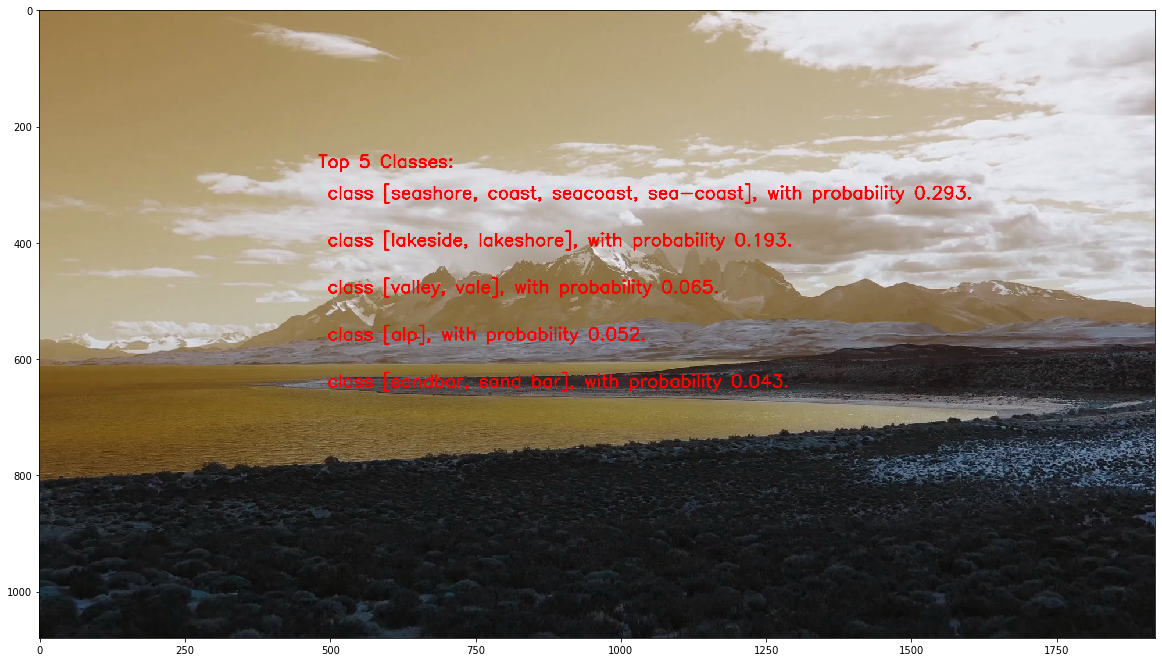

In [13]:
def main():
    image_classifier().run()
    
    
main()

## 4. Deploying Lambda

As mentioned previously, code from above is adapted to run within a notebook environment. You can find actual lambda code in `classification.py` found in the **Lambda** directory. In order to deploy a lambda function from this notebook, you will need the `image-classification.zip` file that contains the following files:
- classification.py
- imagenet-classes.py

### 4.1 Define boto sessions
run the following cell to initialize boto3 to interface with AWS Lambda service

### 4.2 Create the role for Lambda Execution
running the next cell will create an execution role that will deploy your lambda zip file.

In [5]:
role_policy_document = {
    "Version": "2012-10-17",
    "Statement":[
        {
            "Effect": "Allow",
            "Principal": {"Service": ["lambda.amazonaws.com", "events.amazonaws.com"]},
            "Action": "sts:AssumeRole",
        }
    ]
}

iam_client = boto3.client("iam")

iam_client.create_role(
    RoleName="ImageClassificationExecutionRole",
    AssumeRolePolicyDocument=json.dumps(role_policy_document),
)

{'Role': {'Path': '/',
  'RoleName': 'ImageClassificationExecutionRole',
  'RoleId': 'AROAZAPJMVFPFR5RXABA7',
  'Arn': 'arn:aws:iam::619501627742:role/ImageClassificationExecutionRole',
  'CreateDate': datetime.datetime(2020, 11, 6, 22, 44, 2, tzinfo=tzlocal()),
  'AssumeRolePolicyDocument': {'Version': '2012-10-17',
   'Statement': [{'Effect': 'Allow',
     'Principal': {'Service': 'lambda.amazonaws.com'},
     'Action': ['sts:AssumeRole']},
    {'Effect': 'Allow',
     'Principal': {'Service': 'events.amazonaws.com'},
     'Action': ['sts:AssumeRole']}]}},
 'ResponseMetadata': {'RequestId': 'aabba288-9cc6-48f1-af53-c877d64a56cf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'aabba288-9cc6-48f1-af53-c877d64a56cf',
   'content-type': 'text/xml',
   'content-length': '995',
   'date': 'Fri, 06 Nov 2020 22:44:02 GMT'},
  'RetryAttempts': 0}}

### 4.3 Create the AWS Lambda function
Next, the following cell creates the lambda function in your AWS Lambda service and uploads your zip file. 

In [14]:
!zip -o  ../Lambda/image-classification.zip ../Lambda/imagenet_classes.py ../Lambda/classification.py


  adding: ../Lambda/imagenet_classes.py (deflated 58%)
  adding: ../Lambda/classification.py (deflated 64%)


In [10]:
lambda_client = boto3.client('lambda')

with open('../Lambda/image-classification.zip', 'rb') as f:
    zipped_code = f.read()

role = iam_client.get_role(RoleName='ImageClassificationExecutionRole')
response_create_function = lambda_client.create_function(
  FunctionName='ImageClassificationLambda',
  Runtime='python3.7',
  Role=role['Role']['Arn'],
  Handler='classification.main()',
  Code=dict(ZipFile=zipped_code),
  Timeout=120,
  MemorySize=2048,
)

**What is an ARN?** : Amazon Resource Names (ARNs) uniquely identify AWS resources.

The following Python snippet will publish the Lambda Function we created above, and return an ARN with a version. 

This version arn can be used to go directly to the Panorama console and deploy this application.

In [11]:
def printmd(string, color=None):
    """
    Helper Function for Fomatting Output
    """
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

### 4.4 Publish Lambda
Lastly, publish the latest version of you lambda function so that it's available to use in the Panorama Application console. 

In [13]:
response = lambda_client.publish_version(
      FunctionName='ImageClassificationLambda'
  )

Printing the details of the lambda function that was just published

In [16]:
function_arn = response["FunctionArn"]
function_arn_version = list(response["FunctionArn"].split(":"))[-1]
lambda_url = (
    "https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/"
    + response["FunctionName"]
    + "/versions/"
    + response["Version"]
    + "?tab=configuration"
)

printmd("**Function Arn** : **{}**".format(function_arn), color="black")
printmd("**Function Arn Version** : **{}**".format(function_arn_version), color="black")
printmd("**Lambda Console Link** : **{}**".format(lambda_url), color="black")

<span style='color:black'>**Function Arn** : **arn:aws:lambda:us-east-1:619501627742:function:ImageClassificationLambda:1**</span>

<span style='color:black'>**Function Arn Version** : **1**</span>

<span style='color:black'>**Lambda Console Link** : **https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/ImageClassificationLambda/versions/1?tab=configuration**</span>

### 5. Send Model to S3

In [17]:
def send_model_to_s3(model, bucket = 'aws-panorama-models-bucket'):
    s3 = boto3.resource('s3')
    s3.create_bucket(Bucket=bucket)
    
    key = '../../Models/' + model
    
    s3.Object(bucket, model).put(Body=open(key, 'rb'))
    
    bucket_name = bucket
    
    
    location = boto3.client('s3').get_bucket_location(Bucket='aws-panorama-models-bucket')['LocationConstraint']
    url = "s3://{}/{}".format(bucket_name, model)
    
    printmd("**S3 Path** : **{}**".format(url), color="black")
    
    return

In [18]:
send_model_to_s3(model = 'resnet50_v2.tar.gz')

<span style='color:black'>**S3 Path** : **s3://aws-panorama-models-bucket/../Models/resnet50_v2.tar.gz**</span>

### 6 : Deploy the Application

The Lambda is now created and published. You are now ready to deploy your model and the published lambda function, to the Panorama device

The instructions to deploy are linked below

[Creating Application Instructions Here](https://docs.aws.amazon.com/panorama/)